# Protein-protein interactions multilayer network

## Multilayer network

The PPI network consists of 18 connected components (CCs). Each cancer may have deregulated genes in one or more CCs. Red and blue nodes correspond to up- and down-regulated genes. Dark gray edges are interactions shared in at least two cancers, while red ones indicate interactions unique for cancer shown in the multilayer. Nodes with labels are those whom its regulation is cancer specific.


# Load libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
####################################
import networkx as nx
import pymnet
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from itertools import chain
#####################################
from scipy.stats import binom


In [2]:
from math import sqrt

# Define parameters

In [3]:
input_path= '../Datos/'
out_path= 'resultados/'
exp_file= 'DIGs_inall.csv'
path_interacions= '../Datos/String_output_IGs_Octavio/highest_confidence_and_50_interactors/'
path_fasta= '../Datos/Genoma/ensembl/Homo_sapiens.GRCh38.pep.all.fa'
cancers= {'BLCA', 'BRCA', 'COAD', 'ESCA', 'GBM', 'KIRC', 'LUAD', 'PRAD'}
######################################################################
gris= '#E2D5E3'
azul= '#1259ff'
rojo= '#ff1c14'
verde= '66FF19'
dark_gray= '#5B5D61'
negro= '#000000'


# Colormaps

In [4]:
cmap= cm.get_cmap('Accent', 8)
list(map(colors.to_hex, cmap.colors))
#cmap.colors

['#7fc97f',
 '#beaed4',
 '#fdc086',
 '#ffff99',
 '#386cb0',
 '#f0027f',
 '#bf5b17',
 '#666666']

# Load data

## Expression table

In [5]:
df_expresion= pd.read_csv(input_path+exp_file,sep=',')[['Cancer', 'symbols', 'Expression']]
df_expresion.columns= ['cancer_type', 'gene_id', 'expChange']
df_expresion= df_expresion[ df_expresion.cancer_type.isin(cancers) ]

df_expresion['expChange']= df_expresion.expChange.map({'Down-regulated': 'down','Up-regulated': 'up'})

df_expresion


cancer_type gene_id expChange
0          BLCA   OXER1      down
1          BLCA   KCNF1      down
2          BLCA    JUNB      down
3          BLCA   INSM1      down
4          BLCA   CD248      down
..          ...     ...       ...
899        PRAD  H2AC17        up
900        PRAD    H4C2        up
901        PRAD   H3C10        up
902        PRAD  ADRA2A        up
903        PRAD   CLDN8        up

[904 rows x 3 columns]

# Expression dict

In [6]:
dict_expression= dict(df_expresion.groupby('cancer_type').apply(lambda x: dict(np.array(x[['gene_id', 'expChange']]))))


## Interactions table

In [7]:
df_interactions= [(file_name.split("_")[2].upper(),
              pd.read_csv(path_interacions+file_name, sep='\t')
             )
             for file_name in os.listdir(path_interacions)
            ]
    
for cancer, df in df_interactions:
    df['cancer']= cancer
    df['interaction']= list(map(frozenset, zip(df.node1, df.node2)))
    df.drop_duplicates('interaction', inplace= True, ignore_index= True)

df_interactions= [df[['cancer', 'interaction', 'combined_score']] for cancer, df in df_interactions]

df_interactions= pd.concat(df_interactions,
                  ignore_index= True,
                 )

df_interactions


cancer       interaction  combined_score
0       GBM     (AGRP, FOXO1)           0.954
1       GBM      (AGRP, POMC)           0.995
2       GBM      (AGRP, MC4R)           0.999
3       GBM  (ATP5L2, ATP5F1)           0.996
4       GBM    (BUD13, SF3A1)           0.997
...     ...               ...             ...
3080   KIRC    (RBBP7, RBBP4)           0.995
3081   KIRC  (SMARCA5, RBBP7)           0.974
3082   KIRC     (RLN3, RXFP4)           0.994
3083   KIRC     (RLN3, RXFP1)           0.996
3084   KIRC    (RXFP1, RXFP4)           0.985

[3085 rows x 3 columns]

# Cancer-specific interactions

In [8]:
df_uniq_interactions= df_interactions.drop_duplicates('interaction',
                                                      keep= False,
                                                      ignore_index= True)
df_uniq_interactions


cancer       interaction  combined_score
0       GBM     (AGRP, FOXO1)           0.954
1       GBM      (AGRP, POMC)           0.995
2       GBM      (AGRP, MC4R)           0.999
3       GBM  (ATP5L2, ATP5F1)           0.996
4       GBM    (BUD13, SF3A1)           0.997
...     ...               ...             ...
1897   KIRC    (RBBP4, PRMT5)           0.943
1898   KIRC    (RBBP7, PRMT5)           0.945
1899   KIRC     (RLN3, RXFP4)           0.994
1900   KIRC     (RLN3, RXFP1)           0.996
1901   KIRC    (RXFP1, RXFP4)           0.985

[1902 rows x 3 columns]

# Cancer-specific deregulated genes

In [9]:
df_uniq_deregulated= df_expresion[ df_expresion.expChange!='nonde' ].drop_duplicates('gene_id',
                                                                                     keep= False,
                                                                                     ignore_index=True)
df_uniq_deregulated

cancer_type  gene_id expChange
0          BLCA    OXER1      down
1          BLCA     ZXDA      down
2          BLCA     ZXDB      down
3          BLCA    MAS1L      down
4          BLCA  LRRC10B      down
..          ...      ...       ...
111        PRAD   CTAGE8        up
112        PRAD    MARS2        up
113        PRAD    PBOV1        up
114        PRAD    LENG9        up
115        PRAD     H3C1        up

[116 rows x 3 columns]

In [10]:
dict_uniq_dereg= dict(df_uniq_deregulated.groupby('cancer_type').gene_id.agg(set))

In [11]:
{a:len(b) for a,b in dict_uniq_dereg.items()}

{'BLCA': 11,
 'BRCA': 11,
 'COAD': 13,
 'ESCA': 6,
 'GBM': 35,
 'KIRC': 18,
 'LUAD': 6,
 'PRAD': 16}

# Genes classification

In [12]:
set_all_genes= set(chain.from_iterable(df_interactions.interaction))
set_IGs= set(df_expresion.gene_id)
set_nonIGs= set_all_genes.difference(set_IGs)

gene_to_class= {n: 'IGs' for n in set_IGs}
gene_to_class.update({n: 'Interctors' for n in set_nonIGs})


# Graphs creation

## Networkx monoplex

In [13]:
def create_nx_graph(df):
    G= nx.Graph()
    G.add_edges_from(np.array(list(df.interaction)))
    return G

G= create_nx_graph(df_interactions)


In [14]:
# Cargar coordenadas
###################
df_coords= pd.read_csv(out_path+'node_coords.txt')
node_coords= dict(zip(df_coords['index'], map(np.array, zip(df_coords['0'], df_coords['1']) )  ))

#####################33
#node_coords= nx.drawing.nx_agraph.graphviz_layout(G, prog= 'fdp')


# Degree distribution

**Not scale free** $\gamma < 2$  :(


In [15]:
from collections import Counter
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
from math import log, exp

In [16]:
from itertools import repeat

GAMMA parameter: 0.9774234772870822
Pearson correlation coefficient: -0.7908200710069332
Slope error: 6.205291095158113e-11
Bias error: 0.1140419742873824


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(<Figure size 576x360 with 1 Axes>, <Figure size 576x360 with 1 Axes>)

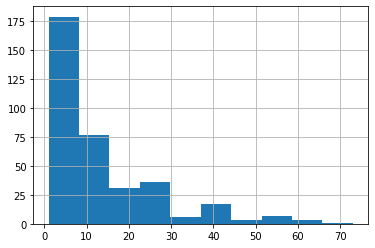

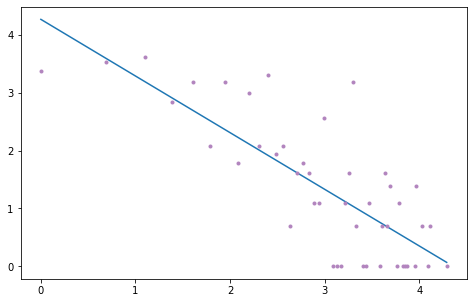

In [17]:
plt.hist(dict(G.degree).values())
plt.grid()

# Obtener distribución de grado
degree_bag= Counter(dict(G.degree).values())

X= list(range( max(degree_bag) + 1  ))
Y= [degree_bag.get(x, 0) for x in X]

#########################################
# Ajustar parámetros

df_points= pd.DataFrame({'X':X, 'Y':Y})
df_points= df_points[ (df_points.X != 0) & (df_points.Y != 0) ]
df_points= df_points.applymap(log)

a_s, b_s, r, tt, stderr= stats.linregress(df_points.X, df_points.Y)

#########################################
"""
fig, ax= plt.subplots(figsize= (8, 5))
for x,y in zip(X,Y):
    ax.plot(x,y, '.',color= '#B284BE')
"""
######################################
# Graficar transformados

xf= max(df_points.X)
Yx= lambda x: b_s + a_s*x

fig0, ax= plt.subplots(figsize= (8, 5))
ax.plot([0, xf], [Yx(0), Yx(xf)])
ax.plot(df_points.X, df_points.Y, '.', color= '#B284BE')

print('GAMMA parameter:', - a_s)
print('Pearson correlation coefficient:', r)
print('Slope error:', tt)
print('Bias error:', stderr)

######################################
# Graficar datos originales

xf= max(X)
b_s= exp(b_s)
Yx= lambda x: b_s * (x**a_s)

fig1, ax= plt.subplots(figsize= (8, 5))

#ax.plot(X, Y, '.', color= '#B284BE')
plt.vlines(X, list(repeat(0, len(X))), Y, colors= '#B284BE')
ax.plot(X[1:], list(map(Yx, X[1:])), color= '#5D8AA8')

ax.set_yscale('log')
ax.grid()

fig0, fig1


# Métrica nodos

In [18]:
betCen0= nx.betweenness_centrality(G)
betCen= nx.degree(G)
sorted_genes= sorted(G, key= lambda x: betCen[x], reverse= True)

df_centralities= pd.DataFrame({'gene_id': sorted_genes,
              'betweenness_centrality': [betCen0[n] for n in sorted_genes],
              'degree_centrality': [betCen[n] for n in sorted_genes],
              'gene_class': [gene_to_class[n] for n in sorted_genes],
             })


def get_IGs_neighbors(x):
    return set([y for y in G[x] if gene_to_class[y]=='IGs'])



df_centralities['IGs_neighbors']= df_centralities.gene_id.apply(get_IGs_neighbors)

df_centralities['IGs_neighbors_prop']= df_centralities.IGs_neighbors.apply(len) / df_centralities.gene_id.apply(lambda x: len(G[x]))

df_centralities['IGs_neighbors']= df_centralities.IGs_neighbors.apply(lambda x: ','.join(x))

df_centralities


gene_id  betweenness_centrality  degree_centrality  gene_class  \
0    HIST1H4F                0.063840                 73  Interctors   
1    HIST1H4J                0.009365                 61  Interctors   
2    HIST1H4E                0.011047                 61  Interctors   
3    HIST1H4B                0.008028                 60  Interctors   
4    HIST1H4C                0.012040                 56  Interctors   
..        ...                     ...                ...         ...   
355     HSPB3                0.000000                  1         IGs   
356     P2RY1                0.000000                  1         IGs   
357       SST                0.000000                  1  Interctors   
358     SSTR5                0.000000                  1         IGs   
359      H1FX                0.000000                  1  Interctors   

    IGs_neighbors  IGs_neighbors_prop  
0                                 0.0  
1                                 0.0  
2                                 0.0  
3                                 0.0  
4                                 0.0  
..            ...                 ...  
355                               0.0  
356                               0.0  
357         SSTR5                 1.0  
358                               0.0  
359                               0.0  

[360 rows x 6 columns]

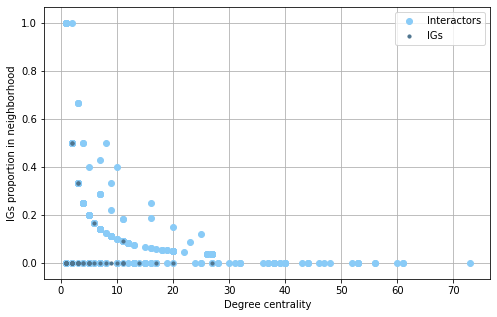

In [19]:
#plt.scatter(df_centralities.betweenness_centrality, df_centralities.IGs_neighbors_prop)

#colrs= list(df_centralities.gene_class.map({'IGs':, 'Interctors': }))
#zord= list(df_centralities.gene_class.map({'IGs':1, 'Interctors': 0}))
df_aux= df_centralities[ df_centralities.gene_class=='Interctors' ]

X= df_aux.degree_centrality
Y= df_aux.IGs_neighbors_prop
plt.scatter(X, Y, c= '#89CBF7', zorder= 2)

####

df_aux= df_centralities[ df_centralities.gene_class=='IGs' ]

X= df_aux.degree_centrality
Y= df_aux.IGs_neighbors_prop
plt.scatter(X, Y, c= '#4F758F', s= 10, zorder= 3)

####

plt.legend(['Interactors', 'IGs'])
plt.grid(zorder=1)

###

p= df_aux.shape[0] / df_centralities.shape[0] # P( Agarrar un IG )
pp= 1/df_centralities.shape[0]  # P( Tomar un nodo en específico al azar )
# P( Estar conectado con un IG al azar ) = P(Tomar un IG y un Int) + P( Tomar 2 IGs) - P(Tomar dos veces el mismo nodo)
ppp= binom.pmf(k= 1, n= 2, p=p) + binom.pmf(k= 2, n= 2, p=p) - binom.pmf(k= 2, n= 2, p=pp)

#plt.plot([0, kmax], [ppp, ppp], '--r')

###

plt.xlabel('Degree centrality')
plt.ylabel('IGs proportion in neighborhood')

fig= plt.gcf()

fig.savefig(out_path+'ppi_metrics/degree_IGs_in_neighborhood.svg')

fig.set_size_inches((8,5))


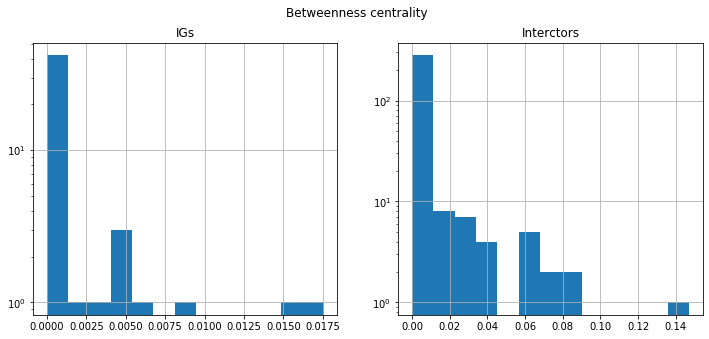

In [20]:
centralities_by_class= df_centralities.groupby('gene_class').betweenness_centrality.agg(list)
#centralities_by_class= df_centralities.groupby('gene_class').degree_centrality.agg(list)

"""
fig1, ax= plt.subplots(figsize= (8, 5))
ax.boxplot(list(centralities_by_class[names]),
            notch= True,
            labels= names
           )
"""
names= list(centralities_by_class.index)
N= len(centralities_by_class)

fig, axs= plt.subplots(1, N, figsize= (6*N,5))#, sharex= True)

for i, name in enumerate(names):
    axs[i].hist(centralities_by_class[name], bins= 13)
    axs[i].set_title(name)
    axs[i].set_yscale('log')
#    axs[i].set_xscale('log')
    axs[i].grid()

#fig.suptitle('betweenness centrality')
fig.suptitle('Betweenness centrality')

fig.savefig(out_path+'ppi_metrics/betweenness_IGs_Interactors.svg')



{'whiskers': [<matplotlib.lines.Line2D at 0x7f7aba3eefd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7aba3d7710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7aba3eee80>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7aba3d7da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7aba3ff128>,
 'means': []}

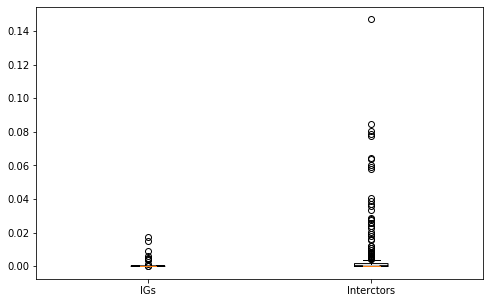

In [21]:
#kolor= nx.centralities_by_class= df_centralities.groupby('gene_class').betweenness_centrality.agg(list)
kolor= nx.centralities_by_class= df_centralities.groupby('gene_class').degree_centrality.agg(list)

names= list(centralities_by_class.index)
fig1, ax= plt.subplots(figsize= (8, 5))

ax.boxplot(list(centralities_by_class[names]),
            notch= True,
            labels= names
           )




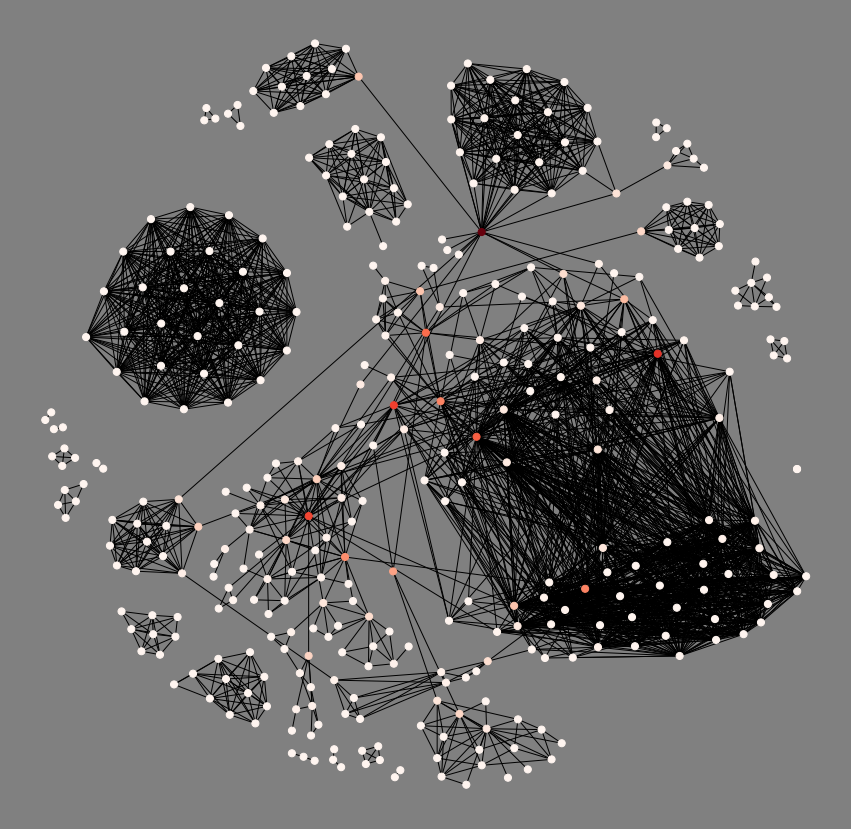

In [22]:
cc1= nx.betweenness_centrality(G)
deg1= nx.closeness_centrality(G)

get_color= lambda n: deg1[n] * cc1[n]

kolor= {a : get_color(a) for a in G}

##################################

fig, ax= plt.subplots(figsize=(15,15))
nx.draw_networkx(G,
                 pos= node_coords,
                 ax= ax,
                 node_color= [kolor[n] for n in G],
                 with_labels= False,
                 cmap= 'Reds',
                 node_size= 50,
                )

face_color= 'gray'

ax.set_facecolor(face_color)
ax.axis('off')
fig.set_facecolor(face_color)



"\n\n\nfig, axs= plt.subplots(1,2, figsize= (8, 4))\n\nAA= [cc[n] for n in set_IGs if n in G]\nlAA= len(AA)\nBB= [cc[n] for n in set_nonIGs if n in G]\nlBB= len(BB)\n\n#axs[0].hist(AA)\n#axs[0].grid()\n#axs[1].hist(BB)\n#axs[1].grid()\n\nfor a,b in Counter(AA).items():\n    axs[0].plot([a,a], [0, b/lAA], color= 'gray')\n    axs[0].grid()\n\nfor a,b in Counter(BB).items():\n    axs[1].plot([a,a], [0, b/lBB], color= 'gray')\n    axs[1].grid()\n\n"

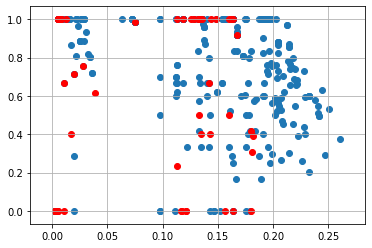

In [55]:
dc= nx.closeness_centrality(G)
cc= nx.clustering(G)
N= len(G)

X= [dc[n] for n in set_nonIGs if n in G]
Y= [cc[n] for n in set_nonIGs if n in G]
plt.scatter(X,Y)

X= [dc[n] for n in set_IGs if n in G]
Y= [cc[n] for n in set_IGs if n in G]
plt.scatter(X,Y, c= 'r')

plt.grid()

"""


fig, axs= plt.subplots(1,2, figsize= (8, 4))

AA= [cc[n] for n in set_IGs if n in G]
lAA= len(AA)
BB= [cc[n] for n in set_nonIGs if n in G]
lBB= len(BB)

#axs[0].hist(AA)
#axs[0].grid()
#axs[1].hist(BB)
#axs[1].grid()

for a,b in Counter(AA).items():
    axs[0].plot([a,a], [0, b/lAA], color= 'gray')
    axs[0].grid()

for a,b in Counter(BB).items():
    axs[1].plot([a,a], [0, b/lBB], color= 'gray')
    axs[1].grid()

"""





Counter({0: 14,
         1.0: 21,
         0.4: 3,
         0.5: 2,
         0.6666666666666666: 2,
         0.23529411764705882: 1,
         0.39285714285714285: 1,
         0.9857549857549858: 1,
         0.41818181818181815: 1,
         0.7142857142857143: 1,
         0.3090909090909091: 1,
         0.6153846153846154: 1,
         0.7555555555555555: 1,
         0.9157894736842105: 1})

In [24]:
#kolor= {a: 1-b for a,b in nx.clustering(G).items()}
kolor= nx.clustering(G)

##################################

fig, ax= plt.subplots(figsize=(15,15))
nx.draw_networkx(G,
                 pos= node_coords,
                 ax= ax,
                 node_color= [kolor[n] for n in G],
                 with_labels= False,
                 cmap= 'Reds',
                 node_size= 50,
                )

face_color= 'gray'

ax.set_facecolor(face_color)
ax.axis('off')
fig.set_facecolor(face_color)


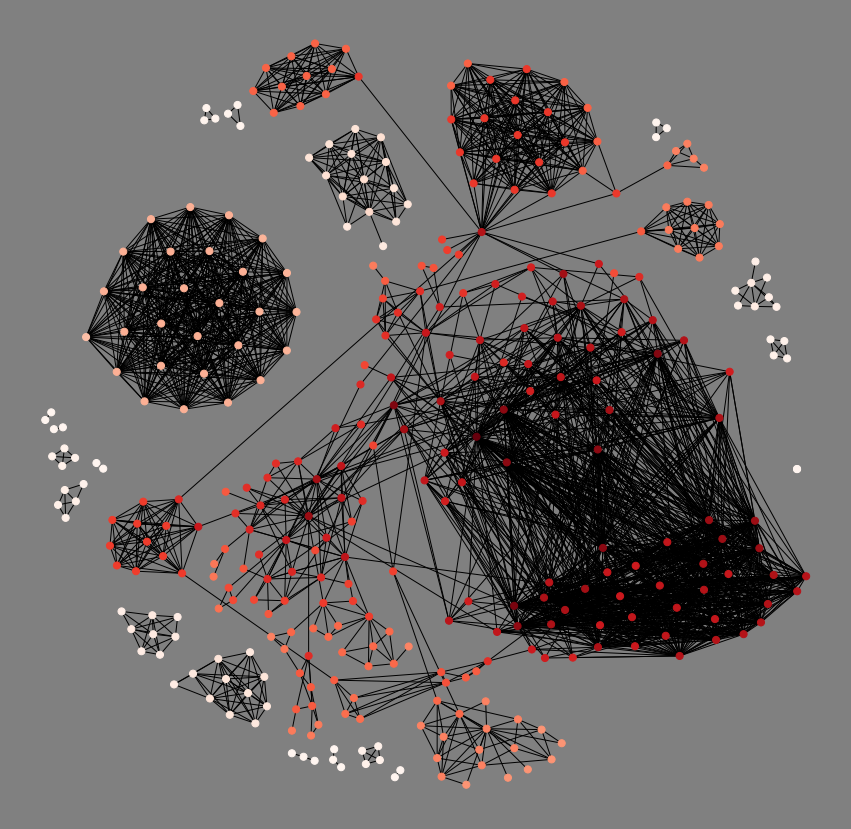

In [25]:
kolor= nx.closeness_centrality(G)


##################################

fig, ax= plt.subplots(figsize=(15,15))
nx.draw_networkx(G,
                 pos= node_coords,
                 ax= ax,
                 node_color= [kolor[n] for n in G],
                 with_labels= False,
                 cmap= 'Reds',
                 node_size= 50,
                )

face_color= 'gray'

ax.set_facecolor(face_color)
ax.axis('off')
fig.set_facecolor(face_color)


# Métricas mariberu

- Entropía kolmogorov-sinai
- asortividad
- otras de kolmogorov

  Medida de aleteoridad de la red


In [26]:
fff= nx.algorithms.assortativity.degree_assortativity_coefficient

fff(G)


0.494621273132061

In [27]:
nNodes= len(G)
maxEdg= nNodes * (nNodes - 1) /2
pEdges= len(G.edges)/maxEdg

X= [fff(nx.random_graphs.erdos_renyi_graph(nNodes, pEdges)) for i in range(100)]

sum(X)/len(X)


-0.007294029307054552